In [1]:
%matplotlib inline

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.insert(1, module_path)
    
from collections import OrderedDict

import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt

from sklearn.isotonic import IsotonicRegression
from calmap import plot_calibration_map
from betacal import BetaCalibration
from utils.utils import MyLogisticRegression

from utils.visualisations import plot_reliability_diagram

from scipy.optimize import minimize_scalar

from scipy.special import gamma
from scipy.special import beta as betaconst

from functools import partial

plt.rcParams['figure.figsize'] = (10, 4)

# Samples from two Beta distributions

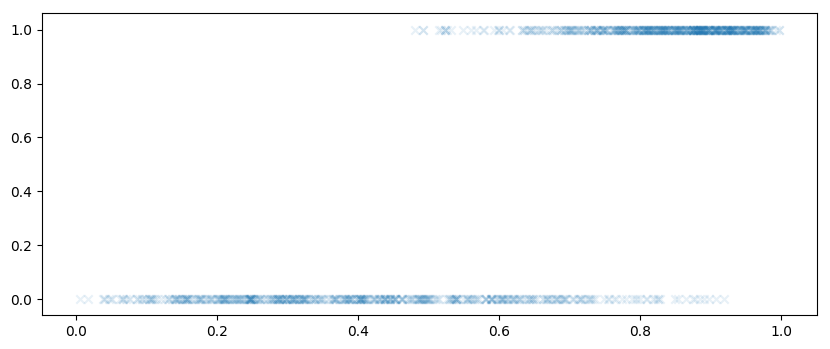

In [2]:
n_samples = 1000
prior0 = 0.5
prior1 = 1-prior0
a0 = 2.0
b0 = 3.0
a1 = 10.0
b1 = 2.0
pos_x = np.random.beta(a0, b0, int(n_samples*prior0))
neg_x = np.random.beta(a1, b1, int(n_samples*prior1))

x = np.hstack((pos_x, neg_x))
y = np.hstack((np.zeros(int(n_samples*prior0)), np.ones(int(n_samples*prior1))))

plt.scatter(x, y, marker='x', alpha=0.1)

## Probability density function of both Betas

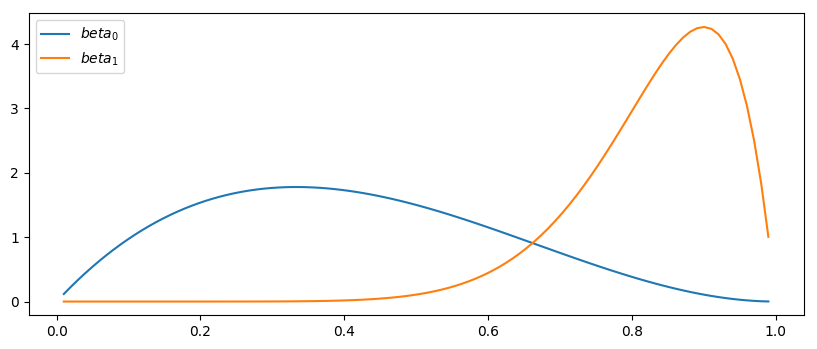

In [3]:
s = np.linspace(0.01, 0.99, 100)

plt.plot(s, beta.pdf(s, a0, b0), label='$beta_0$')
plt.plot(s, beta.pdf(s, a1, b1), label='$beta_1$')
plt.legend()

## Posterior probability of class 1

a0 = 2.0, b0 = 3.0, beta0 = 0.0833333333333, prior0 = 0.5
a1 = 10.0, b1 = 2.0, beta1 = 0.00909090909091, prior1 = 0.5


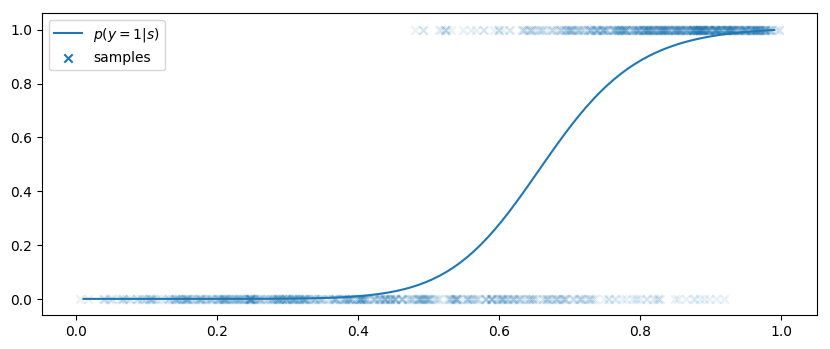

In [4]:
beta0 = betaconst(a0, b0)
beta1 = betaconst(a1, b1)
print('a0 = {}, b0 = {}, beta0 = {}, prior0 = {}'.format(a0, b0, beta0, prior0))
print('a1 = {}, b1 = {}, beta1 = {}, prior1 = {}'.format(a1, b1, beta1, prior1))

def posterior(x, a0, b0, beta0, a1, b1, beta1):
    return np.divide(prior1 * ((x**(a1 - 1))*((1 - x)**(b1 - 1))) / beta1, 
                     prior1 * ((x**(a1 - 1))*((1 - x)**(b1 - 1))) / beta1 + 
                     prior0 * ((x**(a0 - 1))*((1 - x)**(b0 - 1))) / beta0)

posterior1 = partial(posterior, a0=a0, b0=b0, beta0=beta0, a1=a1, b1=b1, beta1=beta1)

plt.scatter(x, y, marker='x', alpha=0.1, label='samples')
plt.plot(s, posterior1(s), label='$p(y=1|s)$')
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)

# Calibration methods

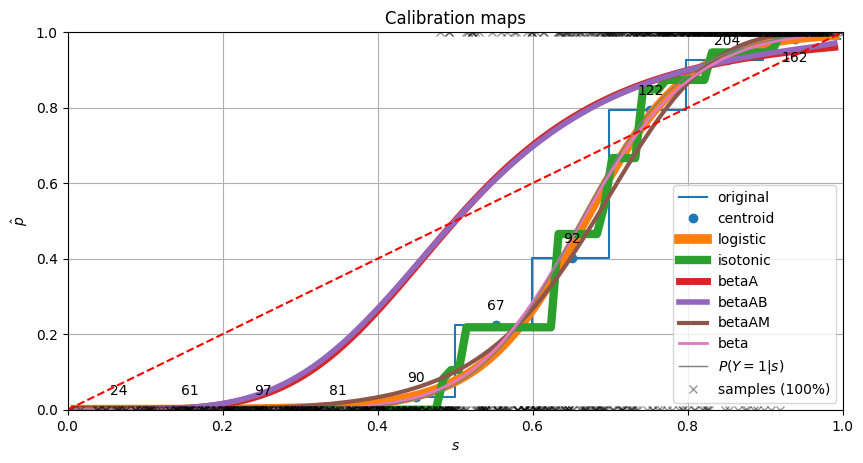

In [5]:
tiny = np.finfo(np.float).eps

lr = MyLogisticRegression(C=99999999999)
iso = IsotonicRegression(out_of_bounds='clip')
bca = BetaCalibration(parameters="a")
bcab = BetaCalibration(parameters="ab")
bcam = BetaCalibration(parameters="am")
bc = BetaCalibration(parameters="abm")

beta_calibrators = OrderedDict([('betaA', bca),
                                ('betaAB', bcab),
                                ('betaAM', bcam),
                                ('beta', bc),
                                ])

calibrators = OrderedDict([('logistic', lr),
                           ('isotonic', iso)]
                         )
calibrators.update(beta_calibrators)

# Train calibrators
calib_map = OrderedDict()
for key in calibrators.keys():
    calibrators[key].fit(x, y)
    # Generate calibration map
    calib_map[key] = calibrators[key].predict(s)
    
calib_map['$P(Y=1|s)$'] = posterior1(s)

fig = plt.figure('rel_map', figsize=(10,5))
fig = plot_reliability_diagram(x, y, s,
                         calib_map.values(),
                         legend_set=calib_map.keys(),
                         alpha=tiny, scatter_prop=1.0,
                         title='Calibration maps',
                         fig=fig)

# Finding intersection parameter

We want to know at wat point the posterior probabilities cross the 0.5 value

$$
\begin{aligned}
P(y=1 | x) & = \frac{P(x | Y=1) P(Y=1)}{\sum_{i=0}^1 P(x | Y=i) P(Y=i)} \\
           & = \frac{P(x | Y=1) P(Y=1)}{\sum_{i=0}^1 P(x | Y=i) P(Y=i)} \\
           & = \frac{x^{\alpha_1 - 1} (1 - x)^{\beta_1 - 1}}{B(\alpha_1, \beta_1)} P(Y=1) /
            \sum_{i=0}^1 \frac{x^{\alpha_i - 1} (1 - x)^{\beta_i - 1}}{B(\alpha_i, \beta_i)} P(Y=i) \\
           & = 0.5
\end{aligned}
$$

Then we can issolate $x$ on the left side:

$$
\begin{aligned}
\frac{x^{\alpha_1 - 1} (1 - x)^{\beta_1 - 1}} {\sum_{i=0}^1 x^{\alpha_i - 1} (1 - x)^{\beta_i - 1}} 
            &= 0.5 \sum_{i=0}^1  \frac{P(Y=i)B(\alpha_1, \beta_1)}{P(Y=1) B(\alpha_i, \beta_i)} \Rightarrow  \\
(\alpha_1-1)\log(x) + (\beta_1-1)\log(1 - x) - \log\left(x^{\alpha_0 - 1} (1 - x)^{\beta_0 - 1} + x^{\alpha_1 - 1} (1 - x)^{\beta_1 - 1}\right) 
            &= \log\left(0.5 \sum_{i=0}^1  \frac{P(Y=i)B(\alpha_1, \beta_1)}{P(Y=1) B(\alpha_i, \beta_i)}\right)
\end{aligned}
$$

It is not possible to issolate the x given that the variables $\alpha$ and $\beta$ are in the exponent. We will require to use optimization methods to find the crossing point

     fun: 2.6646645974736123e-11
 message: 'Solution found.'
    nfev: 11
  status: 0
 success: True
       x: 0.66197434316579118


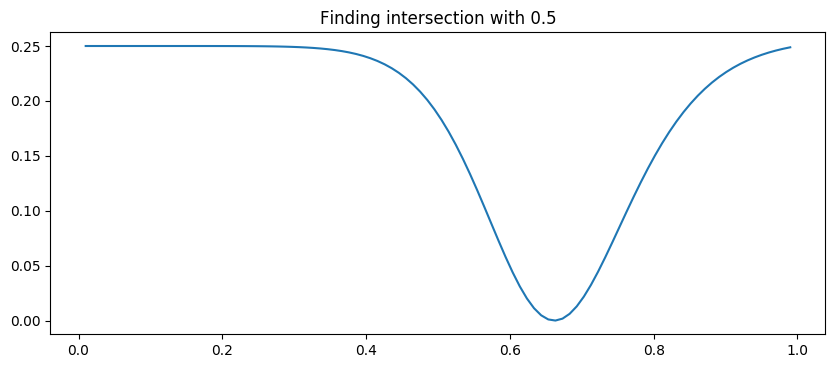

In [6]:
def posterior1_intersection(s, intersect=0.5):
    return (posterior1(s) - intersect)**2

plt.plot(s, posterior1_intersection(s))
plt.title('Finding intersection with 0.5')

result = minimize_scalar(posterior1_intersection, bounds=[0, 1], method='bounded')

print result

# Mean Squared Error of the estimated parameters

In [7]:
m = result.x

a = a1 - a0
b = b0 - b1
print('Original values :\t a = {:0.2f}, b = {:0.2f}, m = {:0.2f}'.format(a,b,m))
for key, calibrator in beta_calibrators.items():
    mse = np.mean([(i-j)**2 for i,j in zip([a,b,m], calibrator.calibrator_.map_)])
    print('Estimated ({0}) :\t a = {2:0.2f}, b = {3:0.2f}, m = {4:0.2f} (MSE = {1:0.2f})'.format(
            key, mse, *calibrator.calibrator_.map_))

Original values :	 a = 8.00, b = 1.00, m = 0.66
Estimated (betaA) :	 a = 4.65, b = 4.65, m = 0.50 (MSE = 8.19)
Estimated (betaAB) :	 a = 4.40, b = 0.13, m = 0.50 (MSE = 4.59)
Estimated (betaAM) :	 a = 2.92, b = 2.92, m = 0.68 (MSE = 9.83)
Estimated (beta) :	 a = 7.52, b = 0.96, m = 0.66 (MSE = 0.08)
